In [ ]:
# Reservoir Analysis for Bear Creek

In [ ]:
from tqdm import tqdm

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

import geopandas as gpd
import pyproj as proj

In [4]:
# Physical Data
MG_to_cfs = 1.547 #cfs*day^-1/1e6 gallons*day^-1
seconds_in_day = 24*60*60

DA_arcade = 332 #drainage area of Arcade (sq mi)
flow_pumpsite = 60.4 # non-depletable flow at pumpsite (cfs)
pump_capacity =  92.82 #cfs
DA_reservoir = 8.215234375 #sq mi
flow_reservoir_min = 4 #non-depletable flow out of reservoir (cfs)
SAE = pd.read_csv('Bear Creek_reservoirSAE.csv')
SAE['Cumulative Percentage of Volume'] = np.float_([str.strip(percent,'%') for percent in SAE['Cumulative Percentage of Volume']])
SAE_volume = SAE['Reservoir Volume \n(MG)']
SAE_surfacearea = SAE['Surface Area (sq ft)']
maximum_storage = np.float(MG_to_cfs*SAE[SAE['Cumulative Percentage of Volume']==100]['Reservoir Volume \n(MG)'])#maximum storage of reservoir, converted to cfs 
minimum_storage = MG_to_cfs * 488.1 

In [5]:
arcade_flow = pd.read_csv('arcade_flow.csv', parse_dates=[0], names=['dates','flow_at_arcade'])

In [6]:
evap_rate = pd.read_csv('evap_rate.csv')

In [7]:
evap_rate['Net Evap in ft/day'][0]

-0.00655913973848025

In [8]:
arcade_flow

,dates,flow_at_arcade
0,1982-01-01,1685.025126
1,1982-01-02,1618.291457
2,1982-01-03,1176.180905
3,1982-01-04,3478.492462
4,1982-01-05,6297.989950
...,...,...
11683,2013-12-27,631.347222
11684,2013-12-28,542.938754
11685,2013-12-29,1596.256992
11686,2013-12-30,1255.471000


In [9]:
flow_pumpsite_actual = [min(x,flow_pumpsite) for x in arcade_flow.flow_at_arcade] #timeseries of flow to pumpsite

In [10]:
pumped = [max(min(pump_capacity,x),0) for x in arcade_flow.flow_at_arcade-flow_pumpsite_actual] #timeseries of pumped water from available reservoir volume


In [11]:
flow_reservoir = arcade_flow.flow_at_arcade * DA_reservoir/DA_arcade   #timeseries of flow into reservoir (scaled by reservoir area/basin area

In [12]:
flow_surplus = flow_reservoir-[min(x,flow_reservoir_min) for x in flow_reservoir]

In [13]:
available = flow_surplus+pumped

available

0        130.515411
1        128.864107
2        117.924222
3        174.894189
4        244.661758
            ...    
11683    104.442486
11684    102.254847
11685    128.318871
11686    119.886230
11687    108.103921
Name: flow_at_arcade, Length: 11688, dtype: float64

In [14]:
n = 15 #how many guesses 

demand_ls = np.linspace(29,30,n) #the range of guesses

storage = np.zeros([len(available),n])
storage[0,:] = maximum_storage

evaporation_ts = np.zeros([len(available),1])
SA_ts = np.zeros([len(available),1])
SA_U_ts = np.zeros([len(available),1])

In [15]:

for j in tqdm(np.arange(0,len(demand_ls))):
    demand = demand_ls[j]
    for i in np.arange(1,len(available)):
        index = np.argmin(np.abs(SAE_volume-storage[i-1,j]/MG_to_cfs))
        #lower, upper bounds of reservoir volume at timestep i
        [vol_L, vol_U] = SAE_volume[index], SAE_volume[index+1]
        #lower, upper bounds of reservoir surface area at timestep i
        [SA_L, SA_U] = SAE_surfacearea[index],SAE_surfacearea[index+1]
        evap_loss = evap_rate['Net Evap in ft/day'][i]/seconds_in_day * (SA_L + (storage[i-1,j]/MG_to_cfs - vol_L)/(vol_U-vol_L)*(SA_U-SA_L))
        demand_cfs = demand * MG_to_cfs
        storage_endofday = min(storage[i-1,j]-demand_cfs-evap_loss+available[i-1],maximum_storage)
        storage[i,j] = storage_endofday
        del index, vol_L, vol_U, SA_L, SA_U

100%|██████████| 15/15 [01:14<00:00,  4.93s/it]


Text(0.5, 0, 'Date')

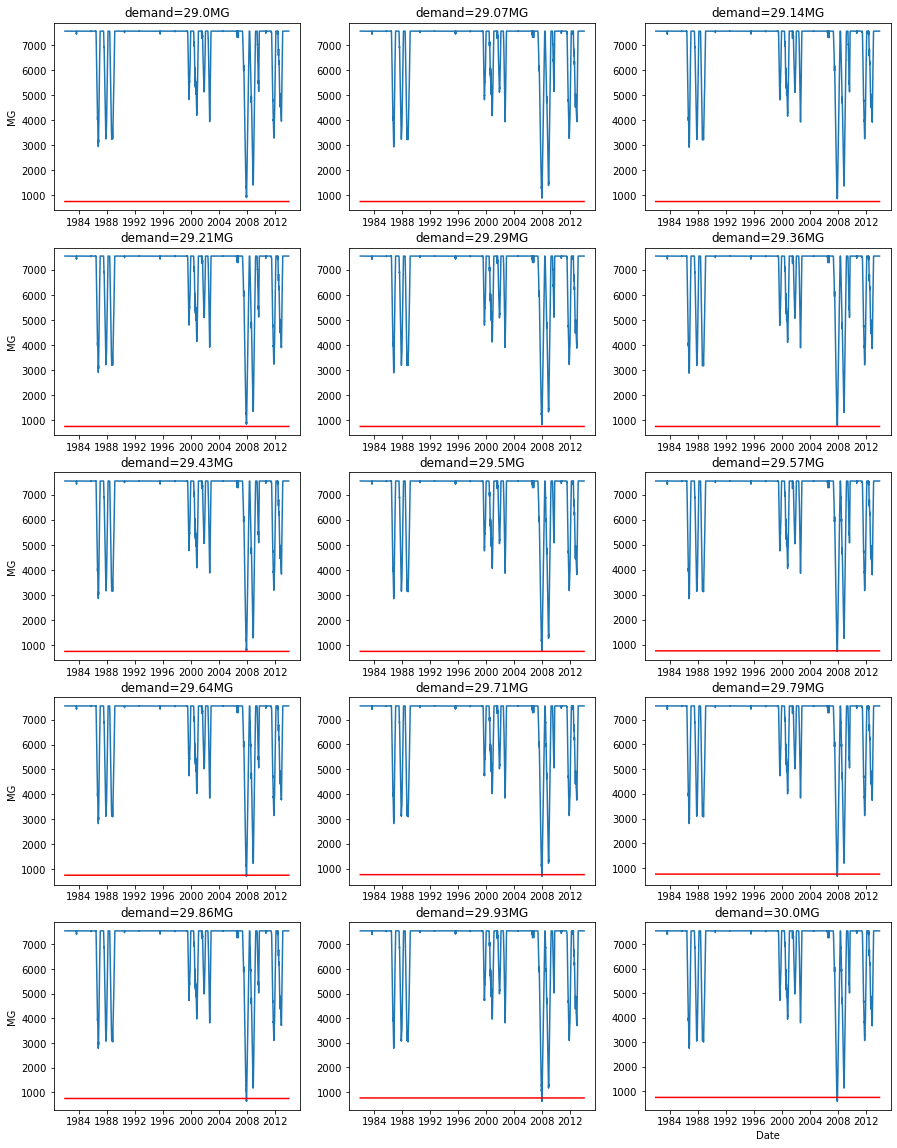

In [16]:
fig, ax = plt.subplots(ncols=int(n/5), nrows=int(n/3),figsize=[15,20])
[nc, nr] = ax.shape
count = 0
for i in np.arange(0,nc):
    for j in np.arange(0,nr):
        ax[i,j].plot(arcade_flow.dates,storage[:,count])
        ax[i,j].plot(arcade_flow.dates,minimum_storage*np.ones([len(arcade_flow.dates),1]),'r')
        ax[i,j].set(title='demand='+str(np.round(demand_ls[count],2))+ 'MG')
        if count%3==0:
            ax[i,j].set(ylabel='MG')
        
        count = count+1


plt.xlabel('Date')

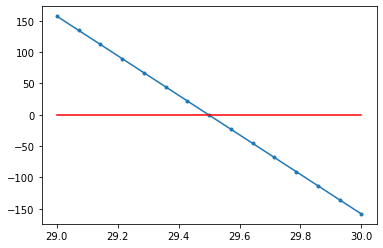

In [17]:
plt.figure()
plt.plot(demand_ls,(np.min(storage,0)-minimum_storage),'.-')
plt.plot(demand_ls,np.zeros(demand_ls.shape),'r')

In [18]:
index = np.argmin(abs(np.min(storage,0)-minimum_storage))
index

7

In [19]:
demand_ls[index]

29.5